<a href="https://colab.research.google.com/github/Auzek2002/Brain_Tumor_Detection_CNN_VGG16/blob/main/Brain_Tumor_Detection_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libs:**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.layers import BatchNormalization
from zipfile import ZipFile

# **Loading Dataset:**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
file = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
x = []
y = []
class_names = ['no','yes']
img_size = 224
for i in class_names:
    folder_path = os.path.join('/content/brain_tumor_dataset',i)
    for j in os.listdir(folder_path):
        img = cv.imread(os.path.join(folder_path,j))
        img = cv.resize(img,(img_size,img_size))
        x.append(img)
        y.append(i)
x = np.array(x)
y = np.array(y)

In [ ]:
x,y = shuffle(x,y,random_state=101)

In [ ]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (253, 224, 224, 3)
Shape of Y: (253,)


In [ ]:
print(f"Shape of one example: {x[0].shape}")

Shape of one example: (224, 224, 3)


# **Displaying Some Images:**

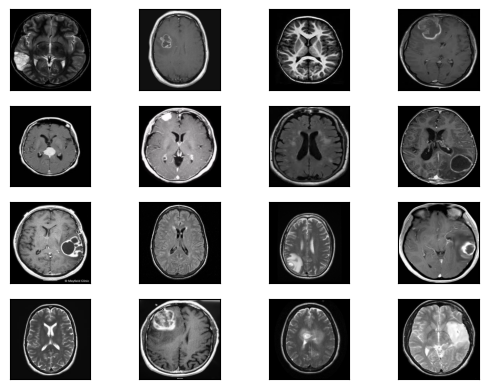

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

# **Train Test Split**

In [ ]:
x_train , x_test , y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (202, 224, 224, 3)
Shape of x_test: (51, 224, 224, 3)
Shape of y_train: (202,)
Shape of y_test: (51,)


# **Label Encoding**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(class_names.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(class_names.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Using VGG16 Neural Network (Transfer Learning)**

In [ ]:
from keras.applications import vgg16

In [ ]:
r , c = 224 ,224
vgg = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(r,c,3))

In [ ]:
#No need to train pre-trained layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
def vgg_model(bottom_model,classes):
  top_model=bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(64,activation='relu')(top_model)
  top_model = Dense(32,activation='relu')(top_model)
  top_model = Dense(2,activation='softmax')(top_model)
  return top_model

# **Building the model:**

In [ ]:
model_head = vgg_model(vgg,2)
model = Model(inputs=vgg.input,outputs=model_head)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),initial_epoch=0)

Epoch 1/25
7/7 [==============================] - 3s 208ms/step - loss: 0.6803 - accuracy: 0.6485 - val_loss: 0.5758 - val_accuracy: 0.6667
Epoch 2/25
7/7 [==============================] - 1s 157ms/step - loss: 0.3282 - accuracy: 0.8762 - val_loss: 0.3237 - val_accuracy: 0.8627
Epoch 3/25
7/7 [==============================] - 1s 160ms/step - loss: 0.2289 - accuracy: 0.9257 - val_loss: 0.2698 - val_accuracy: 0.8824
Epoch 4/25
7/7 [==============================] - 1s 141ms/step - loss: 0.1357 - accuracy: 0.9604 - val_loss: 0.2564 - val_accuracy: 0.9020
Epoch 5/25
7/7 [==============================] - 1s 138ms/step - loss: 0.1061 - accuracy: 0.9703 - val_loss: 0.2264 - val_accuracy: 0.8824
Epoch 6/25
7/7 [==============================] - 1s 156ms/step - loss: 0.0858 - accuracy: 0.9752 - val_loss: 0.2070 - val_accuracy: 0.9216
Epoch 7/25
7/7 [==============================] - 1s 157ms/step - loss: 0.0621 - accuracy: 0.9950 - val_loss: 0.1922 - val_accuracy: 0.9412
Epoch 8/25
7/7 [====

# **Detecting Tumors:**

In [ ]:
score = model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 117ms/step - loss: 0.1889 - accuracy: 0.9608


In [ ]:
print(f"Accuracy of the model to detect brain tumor is: {score[1]*100:0.2f}%")

Accuracy of the model to detect brain tumor is: 96.08%


# **Model Accuracy is 96.08%!**

# **Detecting Tumors:**

In [ ]:
import random

In [ ]:
x.shape

(253, 224, 224, 3)

In [ ]:
y.shape

(253,)

In [ ]:
index = random.randrange(0, 252, 1)
print(f"The random index is: {index}")

The random index is: 229


Image at index number 229: 


Text(0.5, 0, 'no')

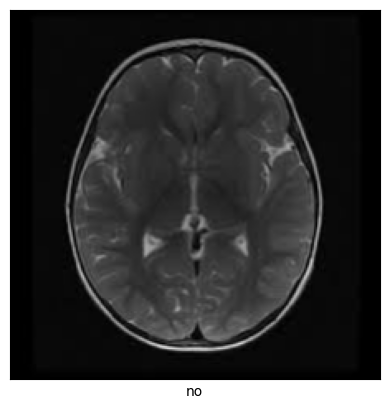

In [ ]:
print(f"Image at index number {index}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index],cmap=plt.cm.binary)
plt.xlabel(y[index])

In [ ]:
x[index].shape

(224, 224, 3)

## *Note an error occurred when predicting the value using only pred = model.predict(x[index]) the reason is that our model was trained on data in the shape of (batch_size, 224, 224, 3) so we need to add an extra dimension*

In [ ]:
# pred = model.predict(x[index])
x_new = x[index]
x_new = tf.expand_dims(x_new, axis=0)

In [ ]:
pred = model.predict(x_new)

1/1 [==============================] - 0s 21ms/step


In [ ]:
pred

array([[0.98228616, 0.01771381]], dtype=float32)

In [ ]:
val = np.argmax(pred)

In [ ]:
print(f"The Prediction made is: {class_names[val]}")

The Prediction made is: no


# **Another one!**

In [ ]:
index2 = random.randrange(0, 252, 1)
print(f"The random index is: {index2}")

The random index is: 57


Image at index number 57: 


Text(0.5, 0, 'yes')

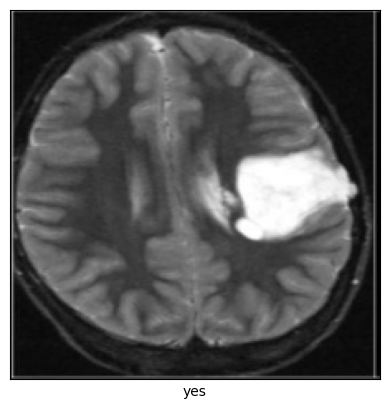

In [ ]:
print(f"Image at index number {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap=plt.cm.binary)
plt.xlabel(y[index2])

In [ ]:
x_new2 = x[index2]
x_new2 = tf.expand_dims(x_new2, axis=0)
pred2 = model.predict(x_new2)
val2 = np.argmax(pred2)

1/1 [==============================] - 0s 19ms/step


In [ ]:
print(f"The Prediction made is: {class_names[val2]}")

The Prediction made is: yes
